##Extracting from instance Concepts

In [1]:
import torch
x = torch.rand(5, 3)
print(x)

tensor([[0.0719, 0.2625, 0.5320],
        [0.9573, 0.5105, 0.2677],
        [0.6588, 0.5889, 0.6210],
        [0.8582, 0.8450, 0.6321],
        [0.8137, 0.4849, 0.4188]])


/home/kaidashova/anaconda3/envs/test4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
torch.cuda.is_available()


True

144 class - Pelican
145 class - Penguin

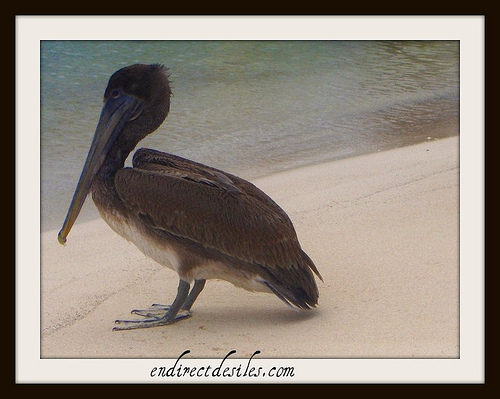

In [3]:
import torch
from torchvision.models.vgg import vgg16_bn
import torchvision.transforms as T
from PIL import Image
from zennit.canonizers import SequentialMergeBatchNorm
from zennit.composites import EpsilonPlusFlat

device = "cuda:1" if torch.cuda.is_available() else "cpu"

model = vgg16_bn(True).to(device)
model.eval()

canonizers = [SequentialMergeBatchNorm()]
composite = EpsilonPlusFlat(canonizers)

transform = T.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor(), T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

image = Image.open("images/pelican.JPEG")
sample = transform(image).unsqueeze(0).to(device)
image


In [4]:
from crp.concepts import ChannelConcept

cc = ChannelConcept()

In [5]:
from crp.helper import get_layer_names
from crp.attribution import CondAttribution
layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])
mask_map = {name: cc.mask for name in layer_names}
layer_map = {layer : cc for layer in layer_names}

attribution = CondAttribution(model)

In [6]:
# compute heatmap wrt. output 144 (pelican class)
conditions = [{"y": 144}]

# zennit requires gradients
sample.requires_grad = True
attr = attribution(sample, conditions, composite, mask_map=mask_map)

True


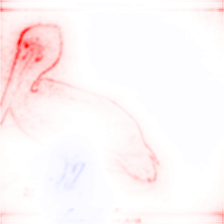

In [7]:
from crp.image import imgify

print(torch.equal(attr[0], attr.heatmap))

imgify(attr.heatmap, symmetric=True)

In [8]:
attr = attribution(sample, conditions, composite, record_layer=layer_names)
# layer features.40 has 512 channel concepts
rel_c = cc.attribute(attr.relevances['features.40'], abs_norm=True)
# the six most relevant concepts and their contribution to final classification in percent
rel_values, concept_ids = torch.topk(rel_c[0], 6)
concept_ids, rel_values*100

(tensor([288, 436,  71, 296, 386, 401], device='cuda:1'),
 tensor([7.5526, 5.1084, 3.0868, 2.5448, 2.4093, 1.9400], device='cuda:1'))

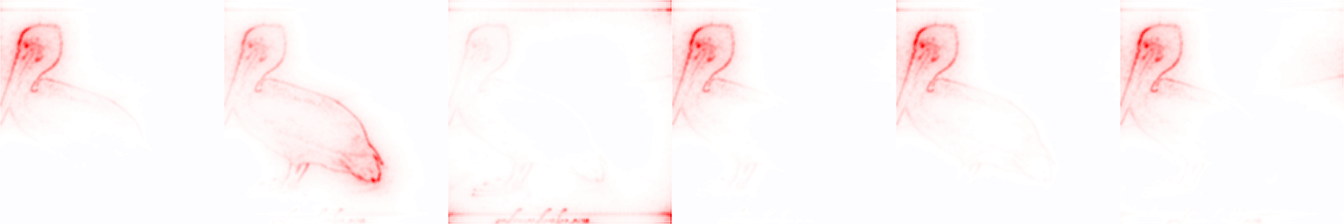

In [9]:
#look at the heatmap of concepts
conditions = [{"features.40": [id], "y": 144} for id in concept_ids]
heatmap, _, _, _ = attribution(sample, conditions, composite)

imgify(heatmap, symmetric=True, grid=(1, len(concept_ids)))

In [10]:
import torchvision
from crp.visualization import FeatureVisualization

preprocessing =  T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
data_path = "../../data/ImageNet_data"
imagenet_data = torchvision.datasets.ImageNet(data_path, transform=transform, split="val")  
fv_path = "../../data/VGG16_ImageNet"
fv = FeatureVisualization(attribution, imagenet_data, layer_map, preprocess_fn=preprocessing, path=fv_path)

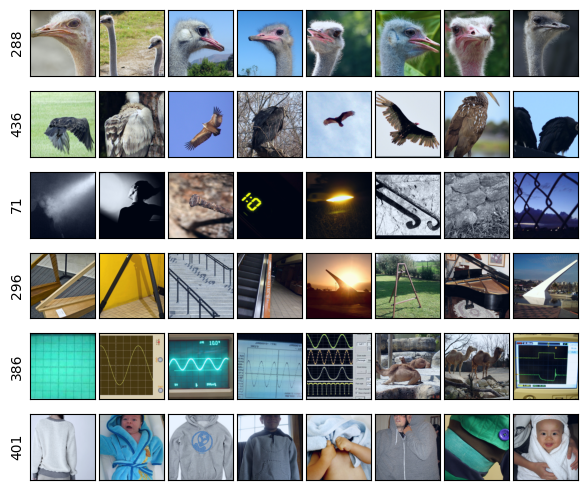

In [13]:
%matplotlib inline
from crp.image import plot_grid

ref_c = fv.get_max_reference([288, 436,  71, 296, 386, 401], "features.40", "relevance", (0, 8))

plot_grid(ref_c, figsize=(6, 5), padding=False)

Pinguine

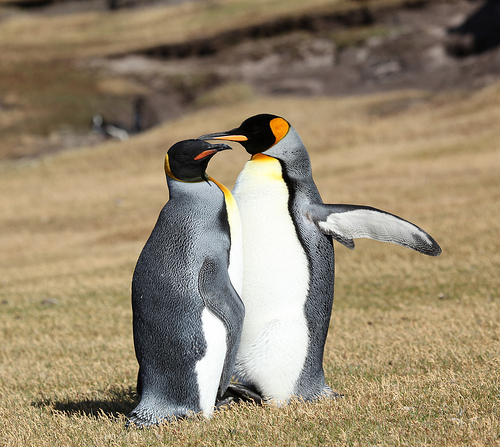

In [14]:
image2 = Image.open("images/pinguine.JPEG")
sample2 = transform(image2).unsqueeze(0).to(device)
image2

True


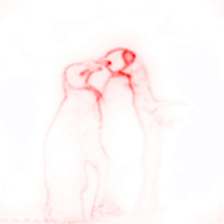

In [17]:
conditions2 = [{"y": 145}]

# zennit requires gradients
sample2.requires_grad = True
attr = attribution(sample2, conditions2, composite, mask_map=mask_map)
from crp.image import imgify

print(torch.equal(attr[0], attr.heatmap))

imgify(attr.heatmap, symmetric=True)

In [18]:
attr = attribution(sample2, conditions2, composite, record_layer=layer_names)
# layer features.40 has 512 channel concepts
rel_c = cc.attribute(attr.relevances['features.40'], abs_norm=True)
# the six most relevant concepts and their contribution to final classification in percent
rel_values, concept_ids = torch.topk(rel_c[0], 6)
concept_ids, rel_values*100

(tensor([349, 419, 506, 352, 380,  71], device='cuda:1'),
 tensor([12.4590,  2.9399,  2.5500,  2.4737,  2.2047,  2.1309], device='cuda:1'))

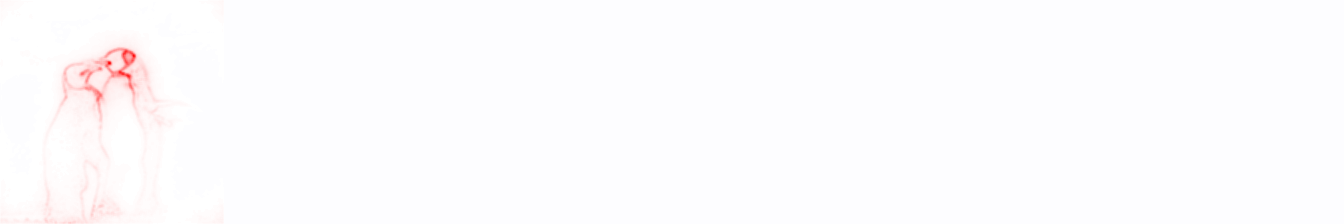

In [20]:
#look at the heatmap of concepts
conditions = [{"features.40": [id], "y": 145} for id in concept_ids]
heatmap, _, _, _ = attribution(sample2, conditions2, composite)

imgify(heatmap, symmetric=True, grid=(1, len(concept_ids)))

In [21]:
import torchvision
from crp.visualization import FeatureVisualization

preprocessing =  T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
data_path = "../../data/ImageNet_data"
imagenet_data = torchvision.datasets.ImageNet(data_path, transform=transform, split="val")  
fv_path = "../../data/VGG16_ImageNet"
fv = FeatureVisualization(attribution, imagenet_data, layer_map, preprocess_fn=preprocessing, path=fv_path)

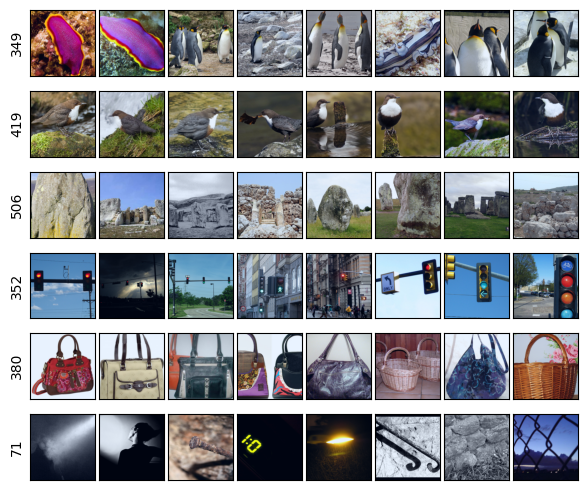

In [27]:
%matplotlib inline
from crp.image import plot_grid

ref_c = fv.get_max_reference([349, 419, 506, 352, 380,  71], "features.40", "relevance", (0, 8))

plot_grid(ref_c, figsize=(6, 5), padding=False)